In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, log_loss, roc_auc_score)

df = pd.read_csv("hexapod_data_cleaned.csv")
X = df.drop(columns=["Label"])
y = df["Label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", C=1.0, gamma="scale", probability=True))
])

svm_pipeline.fit(X_train, y_train)

y_pred = svm_pipeline.predict(X_test)
y_proba = svm_pipeline.predict_proba(X_test)

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(f"\nLog Loss: {log_loss(y_test, y_proba):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba, multi_class='ovr'):.4f}")

clf = svm_pipeline.named_steps["clf"]
feature_names = X.columns

if hasattr(clf, "support_"):
    support_vectors = clf.support_vectors_
    support_indices = clf.support_
    print(f"\nNumber of support vectors: {len(support_indices)}")
    print("Support vector indices:", support_indices)
else:
    print("The SVC model does not provide support vector information.")

Test Accuracy: 0.9567

Classification Report:
              precision    recall  f1-score   support

          -1       0.99      1.00      1.00       189
           0       1.00      0.97      0.99       189
           1       1.00      0.96      0.98       189
           2       1.00      0.94      0.97       189
           3       0.92      0.96      0.94       187
           5       1.00      1.00      1.00       176
           6       0.80      0.86      0.83       185
           7       1.00      0.93      0.96       189
           8       1.00      0.99      1.00       189
           9       1.00      1.00      1.00       189
          10       1.00      1.00      1.00       189
          11       1.00      1.00      1.00       189
          12       0.83      0.95      0.89       188
          13       1.00      0.94      0.97       189
          14       1.00      0.93      0.96       161
          15       0.74      0.78      0.76       186
          16       1.00      1.00  

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import warnings

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Model Performance Visualizations

Confusion Matrix:


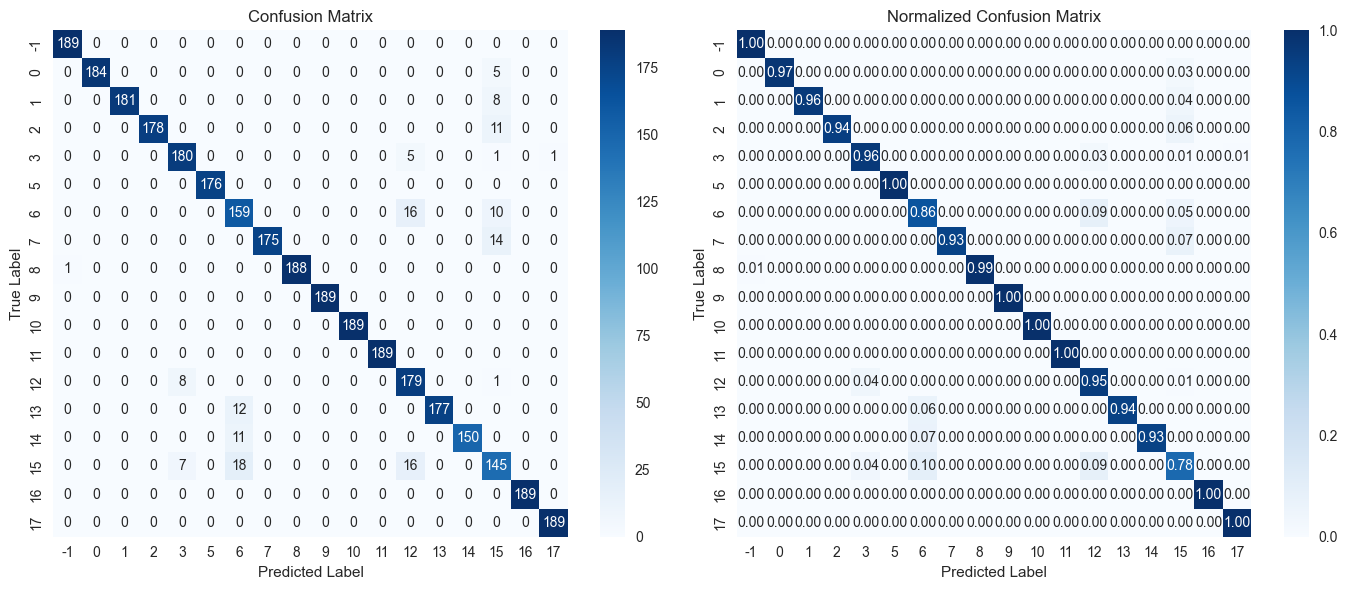

In [5]:
# Confusion Matrix
def plot_confusion_matrix(y_test, y_pred):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0], xticklabels=sorted(y_test.unique()), yticklabels=sorted(y_test.unique()))
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    # Normalized Confusion Matrix
    matrix_normalized = confusion_matrix(y_test, y_pred, normalize='true')
    sns.heatmap(matrix_normalized, annot=True, fmt='.2f', cmap='Blues', ax=axes[1], xticklabels=sorted(y_test.unique()), yticklabels=sorted(y_test.unique()))
    axes[1].set_title('Normalized Confusion Matrix')
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

print("Model Performance Visualizations")
print("=" * 60)
print("\nConfusion Matrix:")
plot_confusion_matrix(y_test, y_pred)


ROC Curves:


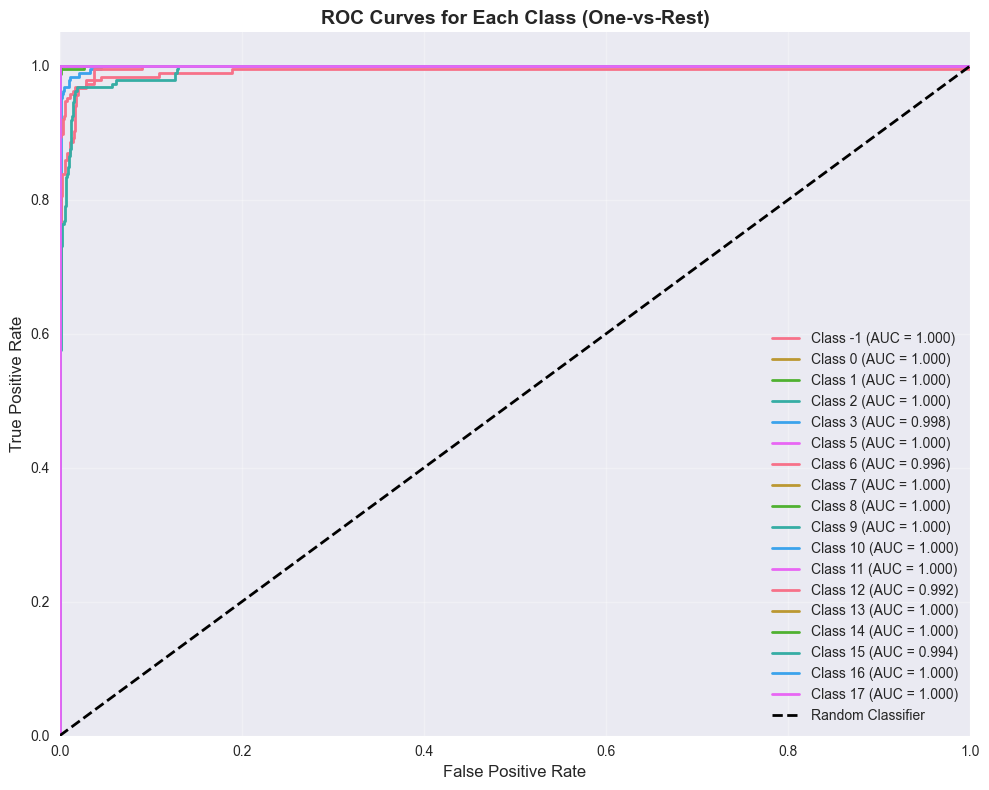

In [7]:
# ROC Curves
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
def plot_roc_curves(y_test, y_proba):
    classes = sorted(y_test.unique())
    n = len(classes)

    y_test_binary = label_binarize(y_test, classes=classes)
    if n == 2:
        y_test_binary = np.hstack((1 - y_test_binary, y_test_binary))

    plt.figure(figsize=(10, 8))

    for i in range(n):
        fpr, tpr, _ = roc_curve(y_test_binary[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, 
                label=f'Class {classes[i]} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves for Each Class (One-vs-Rest)', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("\nROC Curves:")
plot_roc_curves(y_test, y_proba)


Precision-Recall Curves


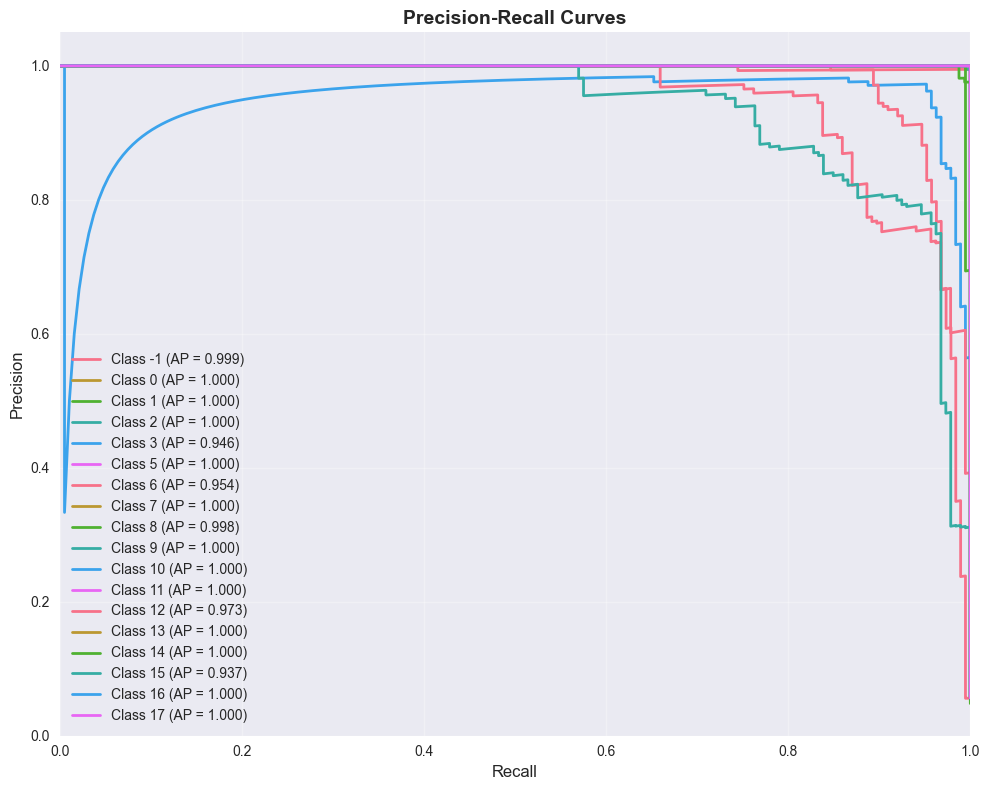

In [ ]:
# Precision Recall Curves
from sklearn.metrics import precision_recall_curve, average_precision_score
def plot_precision_recall_curves(y_test, y_proba):
    classes = sorted(y_test.unique())
    n = len(classes)
    
    y_test_bin = label_binarize(y_test, classes=classes)
    if n == 2:
        y_test_bin = np.hstack((1 - y_test_bin, y_test_bin))
    
    plt.figure(figsize=(10, 8))
    
    for i in range(n):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
        avg_precision = average_precision_score(y_test_bin[:, i], y_proba[:, i])
        plt.plot(recall, precision, lw=2,
                label=f'Class {classes[i]} (AP = {avg_precision:.3f})')
    
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curves', fontsize=14, fontweight='bold')
    plt.legend(loc="lower left")
    plt.grid(True, alpha=0.3)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.tight_layout()
    plt.show()

print("\nPrecision-Recall Curves")
plot_precision_recall_curves(y_test, y_proba)


Learning Curves


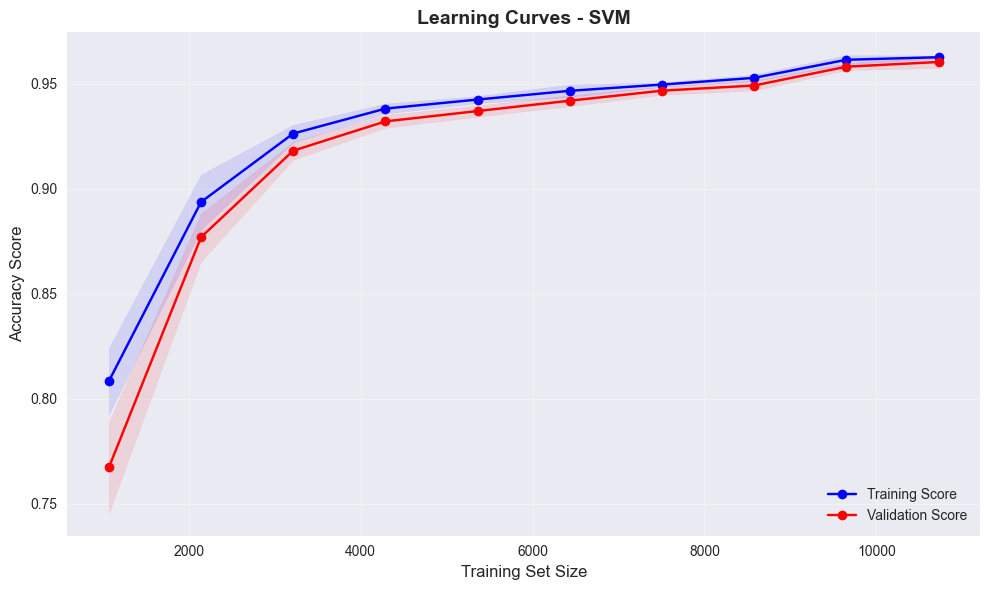


Final Training Score: 0.9626 (+/- 0.0008)
Final Validation Score: 0.9603 (+/- 0.0028)


In [9]:
# Learning Curves
def plot_learning_curves(X_train, y_train, svm_pipeline):
    train_sizes, train_scores, val_scores = learning_curve(
        SVC(kernel="rbf", C=1.0, gamma="scale"),
        X_train, y_train,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5,
        n_jobs=-1,
        scoring='accuracy'
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
    plt.plot(train_sizes, val_mean, 'o-', color='red', label='Validation Score')
    
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std,
                     alpha=0.1, color='blue')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std,
                     alpha=0.1, color='red')
    
    plt.xlabel('Training Set Size', fontsize=12)
    plt.ylabel('Accuracy Score', fontsize=12)
    plt.title('Learning Curves - SVM', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\nFinal Training Score: {train_mean[-1]:.4f} (+/- {train_std[-1]:.4f})")
    print(f"Final Validation Score: {val_mean[-1]:.4f} (+/- {val_std[-1]:.4f})")

print("\nLearning Curves")
plot_learning_curves(X_train, y_train, svm_pipeline)


5. Validation Curves (Hyperparameter Effects)


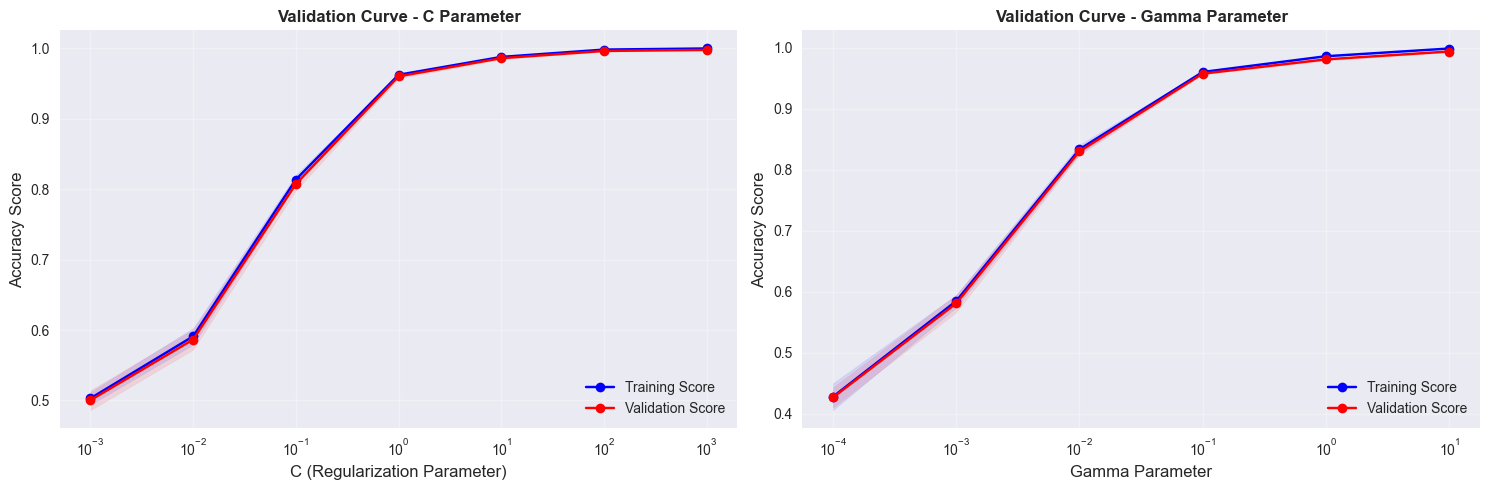

In [ ]:
# Validation Curves, testing different hyperparameters
def plot_validation_curves(X_train, y_train):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    param_range = np.logspace(-3, 3, 7)
    train_scores, val_scores = validation_curve(
        SVC(kernel="rbf", gamma="scale"),
        X_train, y_train,
        param_name="C",
        param_range=param_range,
        cv=5,
        scoring="accuracy",
        n_jobs=-1
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    axes[0].semilogx(param_range, train_mean, 'o-', color='blue', label='Training Score')
    axes[0].semilogx(param_range, val_mean, 'o-', color='red', label='Validation Score')
    axes[0].fill_between(param_range, train_mean - train_std, train_mean + train_std,
                         alpha=0.1, color='blue')
    axes[0].fill_between(param_range, val_mean - val_std, val_mean + val_std,
                         alpha=0.1, color='red')
    axes[0].set_xlabel('C (Regularization Parameter)', fontsize=12)
    axes[0].set_ylabel('Accuracy Score', fontsize=12)
    axes[0].set_title('Validation Curve - C Parameter', fontsize=12, fontweight='bold')
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)
    
    param_range = np.logspace(-4, 1, 6)
    train_scores, val_scores = validation_curve(
        SVC(kernel="rbf", C=1.0),
        X_train, y_train,
        param_name="gamma",
        param_range=param_range,
        cv=5,
        scoring="accuracy",
        n_jobs=-1
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    axes[1].semilogx(param_range, train_mean, 'o-', color='blue', label='Training Score')
    axes[1].semilogx(param_range, val_mean, 'o-', color='red', label='Validation Score')
    axes[1].fill_between(param_range, train_mean - train_std, train_mean + train_std,
                         alpha=0.1, color='blue')
    axes[1].fill_between(param_range, val_mean - val_std, val_mean + val_std,
                         alpha=0.1, color='red')
    axes[1].set_xlabel('Gamma Parameter', fontsize=12)
    axes[1].set_ylabel('Accuracy Score', fontsize=12)
    axes[1].set_title('Validation Curve - Gamma Parameter', fontsize=12, fontweight='bold')
    axes[1].legend(loc='lower right')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("\nValidation Curves (Hyperparameter Effects)")
plot_validation_curves(X_train, y_train)